# Steps in Creating a Data Science Project

1. Defining the project
2. Preparing the data
3. Exploratory data analysis & preprocessing
4. Creating and evaluating a machine learning model
5. Making predictions
6. Presenting your findings

# 1. Defining The Project

    **Business problem description:**


    **Technical problem description:**



# 2. Preparing the data

# Setup Environment

    Import libraries

In [1]:
import pandas as pd
import os

# plot libraries
from matplotlib.axis import Axis  
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import datetime

import numpy as np

# library helper
# run: importnb-install from Conda before using
from importnb import Notebook
with Notebook(): 
    import Utility

# custom helper class (from jupyter notebook)
helper = Utility.Helper()

# progress bars for long running functions
import tqdm

from scipy import stats

from sklearn.cluster import KMeans

import numpy.ma as ma

from IPython.display import Image

Class 'Helper' v1.1 has been loaded


    Function to reload changes in Jupyter notebooks

In [2]:
# reload notebooks
from importlib import reload
with Notebook(): __name__ == '__main__' and reload(Utility)

    Define constants and create control variables

In [3]:
DATA_PATH = '../../data/'

MIN_YEAR = 2009
MAX_YEAR = 2018
FILE_PREFIX = "OJJDP_"

FIGSIZE = (12,9)

#spectrum of chart colors
COLORS = ['#17becf', '#bcbd22', '#7f7f7f', '#e377c2', '#8c564b', '#9467bd', '#d62728', '#2ca02c', '#ff7f0e']

# Import Data
    FBI provides federval-level historical data in single file

In [64]:
fbi_fed_file = DATA_PATH + "Table_01_Crime_in_the_United_States_by_Volume_and_Rate_per_100000_Inhabitants_2001-2020.csv"
    
fbi_fed_df = helper.create_df(fbi_fed_file)

fbi_fed_df.head()

,Year,Population1,Violent\ncrime2,Violent \ncrime \nrate,Murder and\nnonnegligent \nmanslaughter,Murder and \nnonnegligent \nmanslaughter \nrate,Rape\n(revised \ndefinition)3,Rape\n(revised \ndefinition) \nrate3,Rape\n(legacy \ndefinition)4,Rape\n(legacy \ndefinition) \nrate4,...,Aggravated \nassault,Aggravated \nassault rate,Property \ncrime,Property \ncrime \nrate,Burglary,Burglary \nrate,Larceny-\ntheft,Larceny-\ntheft rate,Motor \nvehicle \ntheft,Motor \nvehicle \ntheft \nrate
0,2001,"285,317,559","1,439,480",504.5,"16,037",5.6,NaN,NaN,"90,863",31.8,...,"909,023",318.6,"10,437,189","3,658.10","2,116,531",741.8,"7,092,267","2,485.70","1,228,391",430.5
1,2002,"287,973,924","1,423,677",494.4,"16,229",5.6,NaN,NaN,"95,235",33.1,...,"891,407",309.5,"10,455,277","3,630.60","2,151,252",747.0,"7,057,379","2,450.70","1,246,646",432.9
2,2003,"290,788,976","1,383,676",475.8,"16,528",5.7,NaN,NaN,"93,883",32.3,...,"859,030",295.4,"10,442,862","3,591.20","2,154,834",741.0,"7,026,802","2,416.50","1,261,226",433.7
3,2004,"293,656,842","1,360,088",463.2,"16,148",5.5,NaN,NaN,"95,089",32.4,...,"847,381",288.6,"10,319,386","3,514.10","2,144,446",730.3,"6,937,089","2,362.30","1,237,851",421.5
4,2005,"296,507,061","1,390,745",469.0,"16,740",5.6,NaN,NaN,"94,347",31.8,...,"862,220",290.8,"10,174,754","3,431.50","2,155,448",726.9,"6,783,447","2,287.80","1,235,859",416.8


    FBI also provides agency-level data, these have been collected via web scraper and stored as CSV files, by year

In [29]:
fbi_agency_file = DATA_PATH + "fbi_state_2019.csv"
    
fbi_agency_df = helper.create_df(fbi_agency_file)
fbi_agency_df.head()

,State,State/Tribal/Other,Agency,Unit/Office,Violent crime,Murder and nonnegligent manslaughter,Rape,Robbery,Aggravated assault,Property crime,Burglary,Larceny-theft,Motor vehicle theft,Arson
0,Alabama,Tribal Agencies,Poarch Creek Tribal,NaN,10,0.0,0,5,5,398,6,377,15,0.0
1,Alaska,State Agencies,Alaska State Troopers,NaN,"1,369",23.0,278,65,"1,003","2,985","1,073","1,446",466,47.0
2,Alaska,Tribal Agencies,Metlakatla Tribal,NaN,0,0.0,0,0,0,0,0,0,0,0.0
3,Alaska,Other Agencies,Fairbanks International Airport,NaN,1,0.0,0,0,1,16,0,14,2,0.0
4,Alaska,Other Agencies,Ted Stevens Anchorage International Airport,NaN,6,0.0,0,0,6,107,8,83,16,0.0


    Let's create a state dataframe, summarize stats for the agencies within each state

In [8]:
agency_columns = ['State/Tribal/Other', 'Agency', 'Unit/Office']

fbi_state_df = pd.DataFrame(columns = fbi_agency_df.columns.drop(labels=agency_columns), dtype = int)

curr_state = ""
curr_series = pd.Series(index = fbi_state_df.columns, dtype = int)

row_iterator = fbi_agency_df.iterrows()

# wrap function in progress bar
for i in tqdm.tqdm(range(0, fbi_agency_df.shape[0])):

     # grab the next row
    _, next_series = next(row_iterator)
    next_state = next_series['State']
    # drop non-numeric columns and type to integer
    next_series = next_series.drop(labels=agency_columns).drop(labels=['State']).replace(',','', regex=True).fillna(0).astype(int)

    # if the state is the same as the current state, add the rows
    if(curr_state == next_state):
        curr_series.add(next_series)      

    # otherwise, save the state as current
    else:
        curr_state = next_state
        curr_series = next_series   
    
    # in either case, append the series to the dataframe, we'll drop duplicates later
    fbi_state_series = pd.Series([curr_state], index=['State']).append(curr_series)
    fbi_state_df = fbi_state_df.append(fbi_state_series, ignore_index=True)
    
fbi_state_df = fbi_state_df.drop_duplicates(subset=['State'], keep='last')

100%|█████████████████████████████████████████████████████████████████████████████| 1833/1833 [00:07<00:00, 261.63it/s]


In [9]:
fbi_state_df.head()

,State,Violent crime,Murder and nonnegligent manslaughter,Rape,Robbery,Aggravated assault,Property crime,Burglary,Larceny-theft,Motor vehicle theft,Arson
0,Alabama,10,0,0,5,5,398,6,377,15,0
4,Alaska,1369,23,278,65,1003,2985,1073,1446,466,47
19,Arizona,2,0,0,0,2,7,2,4,1,0
22,Arkansas,1,0,0,0,1,7,1,5,1,0
188,California,43,0,0,0,43,1,1,0,0,0


    OJJDP provides data across multiple files, we'll save those to a dictionary of dataframes, and create a new dataframe with summary data (year over year for all-crime)

In [10]:
OJJDP_files = [FILE_PREFIX + str(year) + ".csv" for year in range(MIN_YEAR, MAX_YEAR+1)]

# dict where key is you path and value is dataframe    
all_df = {file: helper.create_df(DATA_PATH + file) for file in OJJDP_files}

# 3. Exploratory data analysis and preprocessing

# Data Cleaning

In [65]:
# let's tidy up the data types and numberic representations for processing
# remove commas, since our values are all numerical representations
# replace any completely empty or entirely space values with NaN
# replace NaN with 0
# change to datatype float
fbi_fed_df = fbi_fed_df.replace('[,]', '', regex=True).replace(r'^\s*$', np.nan, regex=True).fillna(0).astype(float)

# # convert float values to integer
volume_columns = fbi_fed_df.columns[[1, 2, 4, 8, 10, 12, 14, 16, 18, 20]]
fbi_fed_df[volume_columns] = fbi_fed_df[volume_columns].astype(int)

fbi_fed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 22 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Year                                           20 non-null     float64
 1   Population1                                    20 non-null     int32  
 2   Violent
crime2                                 20 non-null     int32  
 3   Violent 
crime 
rate                           20 non-null     float64
 4   Murder and
nonnegligent 
manslaughter          20 non-null     int32  
 5   Murder and 
nonnegligent 
manslaughter 
rate   20 non-null     float64
 6   Rape
(revised 
definition)3                    20 non-null     float64
 7   Rape
(revised 
definition) 
rate3              20 non-null     float64
 8   Rape
(legacy 
definition)4                     20 non-null     int32  
 9   Rape
(legacy 
definition) 
rate4               20 non-nu

In [66]:
# create column for all crime, place it first
fbi_fed_df.insert(loc=0, column='All offenses', value=fbi_fed_df['Violent\ncrime2'] + fbi_fed_df['Property \ncrime'])

fbi_fed_df.head()

,All offenses,Year,Population1,Violent\ncrime2,Violent \ncrime \nrate,Murder and\nnonnegligent \nmanslaughter,Murder and \nnonnegligent \nmanslaughter \nrate,Rape\n(revised \ndefinition)3,Rape\n(revised \ndefinition) \nrate3,Rape\n(legacy \ndefinition)4,...,Aggravated \nassault,Aggravated \nassault rate,Property \ncrime,Property \ncrime \nrate,Burglary,Burglary \nrate,Larceny-\ntheft,Larceny-\ntheft rate,Motor \nvehicle \ntheft,Motor \nvehicle \ntheft \nrate
0,11876669,2001.0,285317559,1439480,504.5,16037,5.6,0.0,0.0,90863,...,909023,318.6,10437189,3658.1,2116531,741.8,7092267,2485.7,1228391,430.5
1,11878954,2002.0,287973924,1423677,494.4,16229,5.6,0.0,0.0,95235,...,891407,309.5,10455277,3630.6,2151252,747.0,7057379,2450.7,1246646,432.9
2,11826538,2003.0,290788976,1383676,475.8,16528,5.7,0.0,0.0,93883,...,859030,295.4,10442862,3591.2,2154834,741.0,7026802,2416.5,1261226,433.7
3,11679474,2004.0,293656842,1360088,463.2,16148,5.5,0.0,0.0,95089,...,847381,288.6,10319386,3514.1,2144446,730.3,6937089,2362.3,1237851,421.5
4,11565499,2005.0,296507061,1390745,469.0,16740,5.6,0.0,0.0,94347,...,862220,290.8,10174754,3431.5,2155448,726.9,6783447,2287.8,1235859,416.8


    For the OJJDP dataframes in our dictionary, we'll create a new dataframe combining years with crime stats for All ages only

In [77]:
years = [str(year) for year in range(MIN_YEAR, MAX_YEAR+1)]

OJJDP_all_ages = pd.DataFrame(columns=years, dtype = str)
OJJDP_all_ages.columns

Index(['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018'],
      dtype='object')

    We can use any of the dataframes to get the "index" of the rows, i.e. the Crime Category, we'll insert this as first column

In [78]:
OJJDP_all_ages.insert(loc=0, column='Offenses', value=all_df['OJJDP_2009.csv']['Offenses'])

    Let's loop through each dataframe and add the column data to this dataframe, storing them as integer type

In [70]:
column = 'All ages'
i = 0

for year in range(MIN_YEAR, MAX_YEAR+1):
    key = OJJDP_files[i]
    OJJDP_all_ages[str(year)] = all_df[key][column].replace('[,]', '', regex=True).fillna('0').astype(int)
    i += 1

In [71]:
all_df['OJJDP_all_ages'] = OJJDP_all_ages

    Looking at the data we can remove the following rows, as they are not reported and no imputed values will be accurate:
    
        Rape
        Sex offenses (except rape & prostitution)	
        Violent Crime Index	

In [72]:
all_df['OJJDP_all_ages'] = all_df['OJJDP_all_ages'].drop([2, 17, 28])

In [73]:
# slice dataframe to only first row (all crime)
all_offenses = all_df['OJJDP_all_ages'].loc[:0, str(MIN_YEAR):str(MAX_YEAR)]
all_offenses

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,13593810,13120950,12408900,12196960,11302100,11205830,10797090,10662250,10554990,10310960


# Data Exploration

<Figure size 432x288 with 0 Axes>

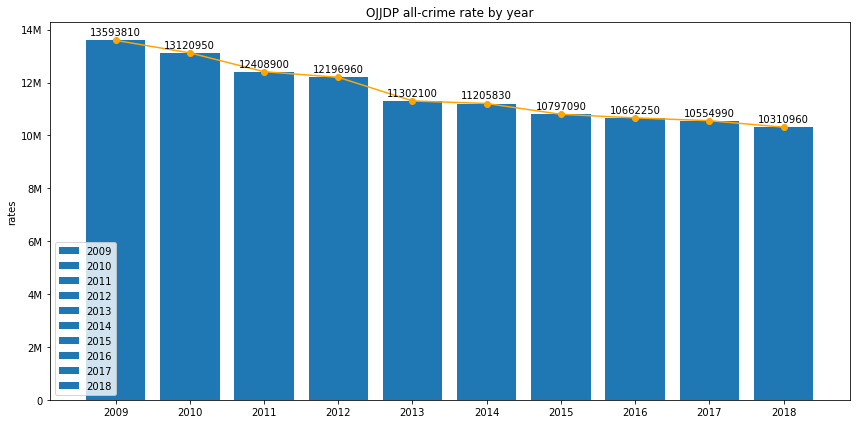

In [74]:
OJJDP_labels = list(all_offenses.columns)
OJJDP_datapoints = all_offenses.loc[0]
helper.plot_barchart(OJJDP_labels, OJJDP_datapoints, 'OJJDP all-crime rate by year', trendline=True)

In [76]:
# create barchart using year from ODDJP chart, to compare
fbi_labels = list(fbi_fed_file['Year'].iloc[8:-2].astype(str))
fbi_datapoints = fbi_fed_file['All offenses'].iloc[8:-2]
helper.plot_barchart(fbi_labels, fbi_datapoints, 'FBI all-crime rate by year', trendline=True)

TypeError: string indices must be integers

    We have created a figure representing the data by state (all crime)

In [ ]:
mean = round(fbi_state_df['Violent crime'].mean(), 0)
std = round(fbi_state_df['Violent crime'].std(), 0)

# Generate data on commute times.
size, scale = 1000, 10

fbi_state_df['Violent crime'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')

plt.title('State Violent Crime Histogram')
plt.text(4050, 35, r'$\mu={mean}, b={std}$'.format(mean=mean, std=std))
plt.xlabel('Counts')
plt.ylabel('Incidents')
plt.grid(axis='y', alpha=0.75)

    Let's remove any values greater than 1 standard deviations from the mean

In [ ]:
one_dev = fbi_state_df['Violent crime'].loc[(np.abs(stats.zscore(fbi_state_df['Violent crime'])) < 1)]

mean = round(one_dev.mean(), 0)
count = one_dev.count()

plt.text(205, 32, r'$\mu={mean}, n={count}$'.format(mean=mean, count=count))

one_dev.plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')

# Data Preprocessing

    Let's create a numpy array of 52 rows and 10 columns. We create a numpy array of data points because the Scikit-Learn library can work with numpy array type data inputs without requiring any preprocessing.

In [ ]:
# make a numpy array of all the numerical columns in the dataframe (all but the first, State)
X = fbi_state_df.iloc[:, 1:].to_numpy()

In [ ]:
plt.scatter(X[:,0],X[:,5], label='True Position')

# 4. Creating and evaluating a machine learning model

In [ ]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(X)

# print the center of each dimension, per cluster
print(kmeans.cluster_centers_)

print(kmeans.labels_)

In [ ]:
# plot the data points in rainbow colors
plt.scatter(X[:,0],X[:,5], c=kmeans.labels_, cmap='rainbow', marker='o')

# plot the centroids in black
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black', marker='.')

       That's not very intuitive unfortunately, let's plot this against a map, with state colors denoted by cluster
       
       source: https://www.kaggle.com/elliotwyman/crime-clusters-over-state-map/

In [ ]:
Image(filename= DATA_PATH + 'state_clusters.png')